In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import sys

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("..")

from xlstm_scaling_laws.analysis.parametric_sclaw_fit.data import (
    create_param_fit_sclaw_data_table,
)
from xlstm_scaling_laws.fitting.fit_parametric_loss.objective_funcs import (
    HoffmannScalingLawObjectiveConfig,
    ScalingLawValidationConfig,
)
from xlstm_scaling_laws.fitting.fit_parametric_loss.plot_parametric_loss_fit import (
    get_model_config_df_dict,
    plot_parametric_loss_fit,
)
from xlstm_scaling_laws.fitting.fit_parametric_loss.run_fit_parametric_loss import (
    FitParametricLossConfig,
    fit_parametric_loss,
)
from xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs import (
    get_first_n_fits_as_fit_fn_dict,
    get_lnd_scaling_law_hoffmann_fn,
)

While loading IsoFLOP Runs: Overriding attention flop calc mode to distill_scaling.
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps16400_nb10_ed512_nh4_pf2.667_gbs512, id=0m5bmumq, path=['xlstm', 'xlstm_jax', '0m5bmumq'], created_at=2025-04-13T06:17:04Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_200M_ctx2048_lr0.003_steps3000_nb27_ed896_nh7_pf2.667_gbs512, id=ch1anxyv, path=['xlstm', 'xlstm_jax', 'ch1anxyv'], created_at=2025-04-13T17:35:13Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps27200_nb10_ed512_nh4_pf2.667_gbs512, id=52pij92y, path=['xlstm', 'xlstm_jax', '52pij92y'], created_at=2025-04-13T08:12:40Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_500M_ctx2048_lr0.002_steps9600_nb27_ed1152_nh9_pf2.667_gbs512, id=oyn1hwkt, path=['xlstm', 'xlstm_jax', 'oyn1hwkt'], created_at=2025-04-14T17:41:

# Scaling Law Fit Playground

This notebook provides step-by-step walkthrough through our scaling law fit pipeline.

We visualize the scaling law fit to assess the fitting quality.

We also try to find a criterion for selecting the best fit out of different fits with different initializations.

In [2]:
df = create_param_fit_sclaw_data_table(model_type="mlstm", experiment_set="isoflop")
df

While loading IsoFLOP Runs: Overriding attention flop calc mode to distill_scaling.


KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps16400_nb10_ed512_nh4_pf2.667_gbs512, id=0m5bmumq, path=['xlstm', 'xlstm_jax', '0m5bmumq'], created_at=2025-04-13T06:17:04Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_200M_ctx2048_lr0.003_steps3000_nb27_ed896_nh7_pf2.667_gbs512, id=ch1anxyv, path=['xlstm', 'xlstm_jax', 'ch1anxyv'], created_at=2025-04-13T17:35:13Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps27200_nb10_ed512_nh4_pf2.667_gbs512, id=52pij92y, path=['xlstm', 'xlstm_jax', '52pij92y'], created_at=2025-04-13T08:12:40Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_500M_ctx2048_lr0.002_steps9600_nb27_ed1152_nh9_pf2.667_gbs512, id=oyn1hwkt, path=['xlstm', 'xlstm_jax', 'oyn1hwkt'], created_at=2025-04-14T17:41:02Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv

,experiment_set_ctx_length,name,run_tag,model_type,num_params,num_tokens_training,num_flops_training,val/.dclm_loss,token_param_ratio,width_depth_ratio,...,embedding_dim,num_blocks,num_heads,proj_factor_ffn,ffn_multiple_of,ffn_dim,head_dim_qk,head_dim_v,IsoFLOP,train/.loss_mean
87,isoflop_ctx8192,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps11500_n...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,1.140347e+08,1.205862e+10,6.028081e+18,3.214503,105.745253,64.000000,...,640,10,5,2.667,64,1728,64.0,128,6e+18,3.214899
88,isoflop_ctx8192,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps19000_n...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,1.140347e+08,1.992294e+10,9.959438e+18,3.173654,174.709549,64.000000,...,640,10,5,2.667,64,1728,64.0,128,1e+19,3.173959
89,isoflop_ctx8192,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps57500_n...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,1.140347e+08,6.029312e+10,3.014040e+19,3.114338,528.726266,64.000000,...,640,10,5,2.667,64,1728,64.0,128,3e+19,3.112180
90,isoflop_ctx8192,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps192000_...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,1.140347e+08,2.013266e+11,1.006427e+20,3.080613,1765.485967,64.000000,...,640,10,5,2.667,64,1728,64.0,128,1e+20,3.080428
91,isoflop_ctx8192,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps9500_nb...,"nb13_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,1.289281e+08,9.961472e+09,5.896365e+18,3.175609,77.263759,49.230769,...,640,13,5,2.667,64,1728,64.0,128,6e+18,3.175550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,isoflop_ctx8192,dclm_mLSTMv1_5.5B_ctx8192_lr0.0009_steps8200_n...,sclaw_iso_round8,mlstm_v1,5.930163e+09,1.719665e+10,5.980413e+20,2.545969,2.899861,99.555556,...,3584,36,14,2.667,64,9600,128.0,256,6e+20,2.547190
260,isoflop_ctx8192,dclm_mLSTMv1_5.5B_ctx8192_lr0.0009_steps9200_n...,sclaw_iso_round8,mlstm_v1,5.311320e+09,1.929380e+10,5.987395e+20,2.531096,3.632580,112.000000,...,3584,32,14,2.667,64,9600,128.0,256,6e+20,2.528684
261,isoflop_ctx8192,dclm_mLSTMv1_4.5B_ctx8192_lr0.0009_steps9600_n...,sclaw_iso_round8,mlstm_v1,5.130622e+09,2.013266e+10,6.047212e+20,2.521995,3.924019,92.444444,...,3328,36,13,2.667,64,8896,128.0,256,6e+20,2.523417
262,isoflop_ctx8192,dclm_mLSTMv1_4.5B_ctx8192_lr0.0009_steps10600_...,sclaw_iso_round8,mlstm_v1,4.597756e+09,2.222981e+10,5.960037e+20,2.519549,4.834926,104.000000,...,3328,32,13,2.667,64,8896,128.0,256,6e+20,2.514902


In [3]:
fit_exp_set = "tokenparam"
val_exp_set = "tokenparam"

token_param_range = [0.0, 5000]

tol = None  # 1e-16
fgtol = 1e-32
other_optimization_kwargs = {
    "options": {
        "ftol": fgtol,
        "gtol": fgtol,
        "maxls": 200,
    },
}
huber_delta = 1e-3  # 1.0
use_logsumexp = True
fit_gamma = False
initialization_grid = {
    "a": [1.0, 5.0],
    "b": [2.0, 6.0],
    "e": [3.0, 7.0],
    "alpha": [0.3],
    "beta": [0.2, 0.4, 0.5],
    # "gamma": [0.0, 0.5, 1.0],
}
# initialization_grid={
#     "a": [0.0, 5.0, 10.0, 15.0, 20.0, 50.0, 100.0, 400.0],
#     "b": [0.0, 5.0, 10.0, 15.0, 20.0, 50.0, 100.0, 400.0],
#     "e": [-1.0, -0.5, 0.0, 0.5, 1.0],
#     "alpha": [0.0, 0.34, 0.5, 1.0, 1.5, 2.0],
#     "beta": [0.0, 0.25, 0.3, 0.5, 1.0, 1.5, 2.0],
# }

# some fits for mlstm
fit_cfg_mlstm = FitParametricLossConfig(
    objective_func_config=HoffmannScalingLawObjectiveConfig(
        huber_delta=huber_delta,
        use_logsumexp=use_logsumexp,
        fit_gamma=fit_gamma,
        reduce_loss="sum",
        target_loss="val",
        model_type="mlstm",
        attention_flop_calc_mode="distill_scaling",
        context_length=8192,
        experiment_set=fit_exp_set,  # "all", "isoflop"
        experiment_set_split="all",
        token_param_range=token_param_range,
    ),
    validation_func_config=ScalingLawValidationConfig(),
    initialization_grid=initialization_grid,
    num_bootstrap_samples=-1,  # 100,
    bootstrap_seed=1,
    method="L-BFGS-B",
    tol=tol,  # None,
    other_optimization_kwargs=other_optimization_kwargs,
)
ret_mlstm = fit_parametric_loss(config=fit_cfg_mlstm)

# some fits for llama
fit_cfg_llama = FitParametricLossConfig(
    objective_func_config=HoffmannScalingLawObjectiveConfig(
        huber_delta=huber_delta,
        use_logsumexp=use_logsumexp,
        fit_gamma=fit_gamma,
        reduce_loss="sum",
        target_loss="val",
        model_type="llama",
        attention_flop_calc_mode="distill_scaling",
        context_length=8192,
        experiment_set=fit_exp_set,
        experiment_set_split="all",
        token_param_range=token_param_range,
    ),
    validation_func_config=ScalingLawValidationConfig(),
    initialization_grid=initialization_grid,
    num_bootstrap_samples=-1,  # 100,
    bootstrap_seed=1,
    method="L-BFGS-B",
    tol=tol,  # None,#1e-16,
    other_optimization_kwargs=other_optimization_kwargs,
)
ret_llama = fit_parametric_loss(config=fit_cfg_llama)

Running optimization: 100%|██████████| 24/24 [00:02<00:00,  9.19it/s]


## Selection by Loss

In [4]:
ret_llama.sort_values(by=("optim_results", "loss"), ascending=True)

idxes                 val_results                                \
   init_idx bootstrap_idx all#r_squared   all#mse  all#rmse   all#mae   
10       10             0   -249.073539  0.139313  0.373247  0.292470   
17       17             0   -249.082567  0.139318  0.373254  0.292475   
12       12             0   -249.078488  0.139316  0.373251  0.292474   
5         5             0   -249.080075  0.139317  0.373252  0.292474   
6         6             0   -249.073003  0.139313  0.373247  0.292469   
8         8             0   -249.076665  0.139315  0.373249  0.292472   
9         9             0   -249.072329  0.139313  0.373246  0.292467   
11       11             0   -249.078873  0.139316  0.373251  0.292469   
19       19             0   -249.071980  0.139312  0.373246  0.292467   
14       14             0   -249.069641  0.139311  0.373244  0.292465   
18       18             0   -249.073679  0.139313  0.373247  0.292482   
20       20             0   -248.968619  0.139255  0.373169  0.292436   
2         2             0   -248.744028  0.139130  0.373001  0.292302   
0         0             0   -249.253212  0.139413  0.373381  0.292233   
16       16             0   -250.340280  0.140019  0.374191  0.294037   
4         4             0   -248.015863  0.138724  0.372457  0.290808   
15       15             0   -248.015474  0.138724  0.372456  0.290808   
13       13             0   -248.015471  0.138724  0.372456  0.290808   
21       21             0   -248.015458  0.138724  0.372456  0.290808   
22       22             0   -242.616376  0.135716  0.368397  0.289015   
23       23             0   -331.323333  0.185134  0.430272  0.353746   
3         3             0   -331.326940  0.185136  0.430274  0.353748   
1         1             0   -331.326787  0.185136  0.430274  0.353748   
7         7             0   -316.563706  0.176911  0.420608  0.344734   

                                                                       ...  \
   tokenparam#r_squared tokenparam#mse tokenparam#rmse tokenparam#mae  ...   
10           -60.830989       0.184754        0.429830       0.348163  ...   
17           -60.833400       0.184761        0.429839       0.348170  ...   
12           -60.831844       0.184757        0.429833       0.348165  ...   
5            -60.831849       0.184757        0.429833       0.348165  ...   
6            -60.831649       0.184756        0.429832       0.348165  ...   
8            -60.831259       0.184755        0.429831       0.348164  ...   
9            -60.831405       0.184755        0.429832       0.348164  ...   
11           -60.832637       0.184759        0.429836       0.348167  ...   
19           -60.831274       0.184755        0.429831       0.348164  ...   
14           -60.830846       0.184754        0.429830       0.348163  ...   
18           -60.834166       0.184763        0.429841       0.348174  ...   
20           -60.824679       0.184735        0.429808       0.348157  ...   
2            -60.797939       0.184655        0.429715       0.348096  ...   
0            -60.696551       0.184352        0.429363       0.347699  ...   
16           -61.195808       0.185844        0.431096       0.349292  ...   
4            -60.257695       0.183041        0.427833       0.346436  ...   
15           -60.257719       0.183041        0.427833       0.346436  ...   
13           -60.257717       0.183041        0.427833       0.346436  ...   
21           -60.257716       0.183041        0.427833       0.346436  ...   
22           -59.867179       0.181874        0.426467       0.345983  ...   
23           -56.318158       0.171269        0.413847       0.336441  ...   
3            -56.318515       0.171270        0.413848       0.336443  ...   
1            -56.318261       0.171270        0.413847       0.336442  ...   
7            -54.019004       0.164399        0.405462       0.329640  ...   

   optim_results                                                           \
 

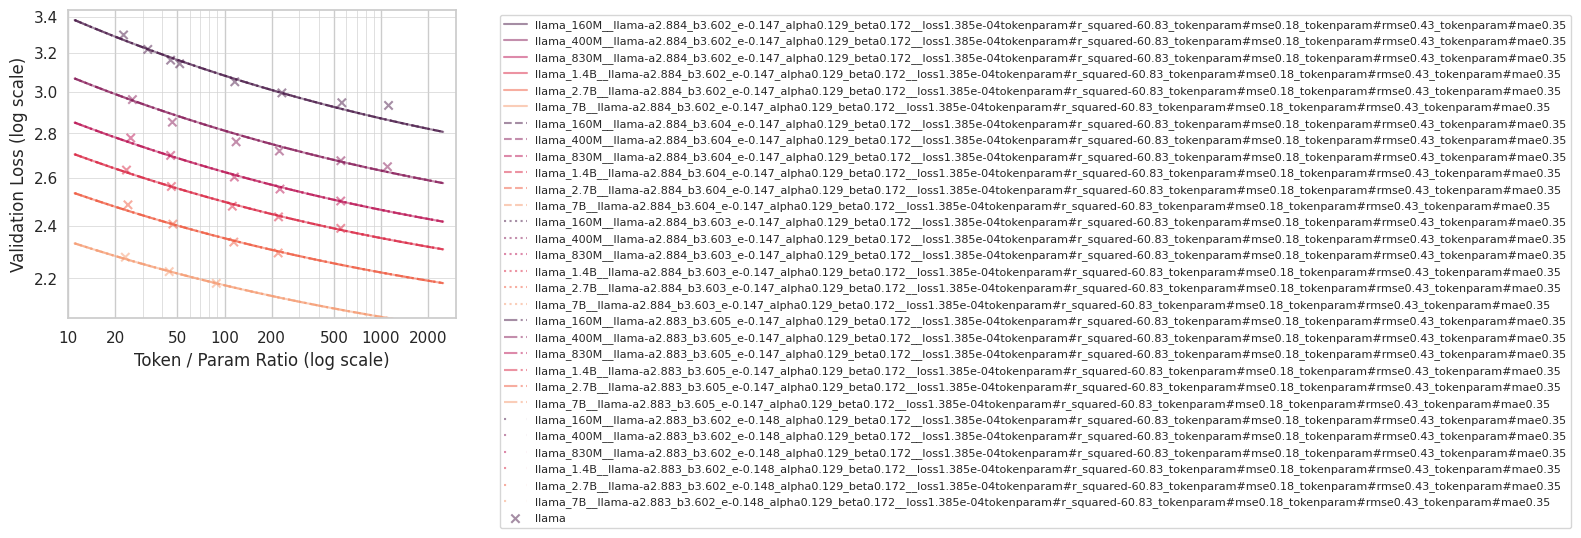

In [5]:
parametric_loss_fn_dicts = {
    "llama": get_first_n_fits_as_fit_fn_dict(
        ret_llama.sort_values(by=("optim_results", "loss"), ascending=True),
        key_prefix="llama-",
        n=5,
        return_mode="logsumexp",
    ),
}
with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        ax = plot_parametric_loss_fit(
            parametric_sclaw_funcs=parametric_loss_fn_dicts,
            model_size_colormap_scale="log",
            x_axis_mode="token_param_ratio",
            plot_mode="compare_sclaw",
            yscale="log",
            xscale="log",
            # token_param_ratio_range=[11., 2500.],
            # xlim=[10, 3000],
            # ylim=[2.05, 3.7],
        )

In [6]:
parametric_loss_fn_dicts

{'llama': {'llama-a2.884_b3.602_e-0.147_alpha0.129_beta0.172__loss1.385e-04tokenparam#r_squared-60.83_tokenparam#mse0.18_tokenparam#rmse0.43_tokenparam#mae0.35': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'llama-a2.884_b3.604_e-0.147_alpha0.129_beta0.172__loss1.385e-04tokenparam#r_squared-60.83_tokenparam#mse0.18_tokenparam#rmse0.43_tokenparam#mae0.35': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'llama-a2.884_b3.603_e-0.147_alpha0.129_beta0.172__loss1.385e-04tokenparam#r_squared-60.83_tokenparam#mse0.18_tokenparam#rmse0.43_tokenparam#mae0.35': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'llama-a2.883_b3.605_e-0.147_alpha0.129_beta0.172__loss1.385e-04tokenparam#r_squared-60.83_tokenparam

In [7]:
ret_mlstm.sort_values(by=("optim_results", "loss"), ascending=True)

idxes                 val_results                                \
   init_idx bootstrap_idx all#r_squared   all#mse  all#rmse   all#mae   
11       11             0   -425.822851  0.113549  0.336971  0.272346   
9         9             0   -425.816143  0.113548  0.336968  0.272343   
5         5             0   -425.801248  0.113544  0.336963  0.272336   
13       13             0   -425.791229  0.113541  0.336959  0.272332   
19       19             0   -425.786261  0.113540  0.336957  0.272330   
10       10             0   -425.786057  0.113540  0.336957  0.272330   
18       18             0   -426.585679  0.113752  0.337272  0.272662   
0         0             0   -423.035635  0.112808  0.335869  0.271557   
2         2             0   -422.740141  0.112729  0.335752  0.271500   
8         8             0   -424.089993  0.113088  0.336286  0.271989   
20       20             0   -423.469282  0.112923  0.336041  0.271749   
12       12             0   -423.385542  0.112901  0.336008  0.271717   
17       17             0   -433.008003  0.115461  0.339796  0.275053   
6         6             0   -423.456213  0.112920  0.336036  0.271828   
15       15             0   -426.012279  0.113600  0.337046  0.271469   
21       21             0   -426.013305  0.113600  0.337046  0.271470   
4         4             0   -426.011970  0.113600  0.337046  0.271469   
14       14             0   -426.011663  0.113600  0.337046  0.271469   
23       23             0   -426.015108  0.113601  0.337047  0.271470   
22       22             0   -426.012098  0.113600  0.337046  0.271469   
16       16             0   -598.714970  0.159545  0.399430  0.329832   
1         1             0   -598.055964  0.159369  0.399211  0.329662   
3         3             0   -598.796737  0.159566  0.399458  0.329864   
7         7             0   -566.058172  0.150857  0.388403  0.317411   

                                                                       ...  \
   tokenparam#r_squared tokenparam#mse tokenparam#rmse tokenparam#mae  ...   
11           -68.465280       0.194223        0.440707       0.357030  ...   
9            -68.464695       0.194221        0.440705       0.357028  ...   
5            -68.465774       0.194224        0.440709       0.357031  ...   
13           -68.466084       0.194225        0.440710       0.357033  ...   
19           -68.466086       0.194225        0.440710       0.357033  ...   
10           -68.466156       0.194225        0.440710       0.357033  ...   
18           -68.444207       0.194164        0.440640       0.356953  ...   
0            -68.037349       0.193026        0.439348       0.356069  ...   
2            -68.388981       0.194010        0.440465       0.357233  ...   
8            -68.529882       0.194403        0.440912       0.357616  ...   
20           -68.561209       0.194491        0.441011       0.357742  ...   
12           -68.565085       0.194502        0.441024       0.357758  ...   
17           -68.341401       0.193877        0.440314       0.356418  ...   
6            -68.301120       0.193764        0.440186       0.357200  ...   
15           -68.583459       0.194553        0.441082       0.357394  ...   
21           -68.583390       0.194553        0.441082       0.357394  ...   
4            -68.583388       0.194553        0.441082       0.357394  ...   
14           -68.583310       0.194553        0.441081       0.357394  ...   
23           -68.583606       0.194554        0.441082       0.357395  ...   
22           -68.583386       0.194553        0.441082       0.357394  ...   
16           -65.670649       0.186409        0.431751       0.350468  ...   
1            -65.609423       0.186238        0.431553       0.350297  ...   
3            -65.669414       0.186406        0.431747       0.350461  ...   
7            -62.984252       0.178898        0.422963       0.343903  ...   

   optim_results                                                           \
 

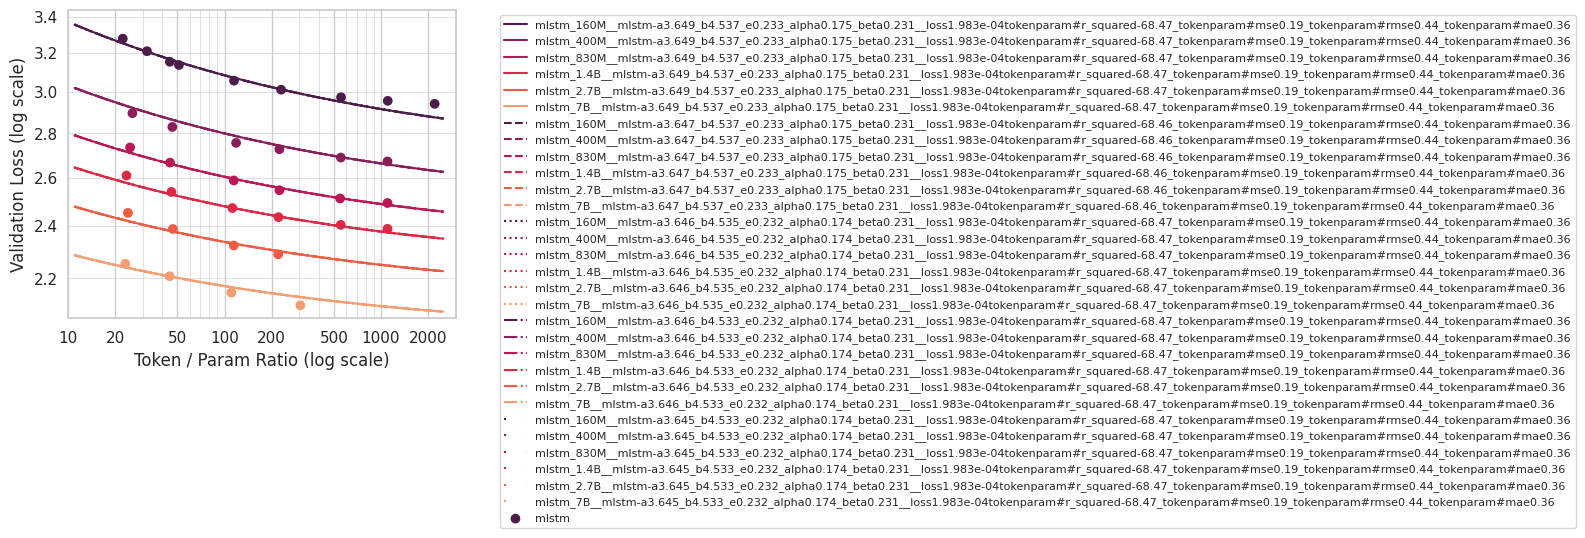

In [8]:
parametric_loss_fn_dicts = {
    "mlstm": get_first_n_fits_as_fit_fn_dict(
        ret_mlstm.sort_values(by=("optim_results", "loss")),
        key_prefix="mlstm-",
        n=5,
        return_mode="logsumexp",
    ),
    # "llama": get_first_n_fits_as_fit_fn_dict(
    #     ret_llama["optim_params"], key_prefix="llama-", n=3
    # ),
}
with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        ax = plot_parametric_loss_fit(
            parametric_sclaw_funcs=parametric_loss_fn_dicts,
            model_size_colormap_scale="log",
            x_axis_mode="token_param_ratio",
            plot_mode="compare_sclaw",
            yscale="log",
            xscale="log",
            # token_param_ratio_range=[11., 2500.],
            # xlim=[10, 3000],
            # ylim=[2.05, 3.7],
        )

In [9]:
parametric_loss_fn_dicts

{'mlstm': {'mlstm-a3.649_b4.537_e0.233_alpha0.175_beta0.231__loss1.983e-04tokenparam#r_squared-68.47_tokenparam#mse0.19_tokenparam#rmse0.44_tokenparam#mae0.36': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'mlstm-a3.647_b4.537_e0.233_alpha0.175_beta0.231__loss1.983e-04tokenparam#r_squared-68.46_tokenparam#mse0.19_tokenparam#rmse0.44_tokenparam#mae0.36': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'mlstm-a3.646_b4.535_e0.232_alpha0.174_beta0.231__loss1.983e-04tokenparam#r_squared-68.47_tokenparam#mse0.19_tokenparam#rmse0.44_tokenparam#mae0.36': <function xlstm_scaling_laws.fitting.fit_parametric_loss.scaling_law_funcs.get_lnd_scaling_law_hoffmann_fn.<locals>.<lambda>(nparams, ntoks)>,
  'mlstm-a3.646_b4.533_e0.232_alpha0.174_beta0.231__loss1.983e-04tokenparam#r_squared-68.47_tokenparam#mse

## Selection by validation criterion

In [13]:
ret_mlstm

idxes                 val_results                                \
   init_idx bootstrap_idx all#r_squared   all#mse  all#rmse   all#mae   
0         0             0   -423.035635  0.112808  0.335869  0.271557   
1         1             0   -598.055964  0.159369  0.399211  0.329662   
2         2             0   -422.740141  0.112729  0.335752  0.271500   
3         3             0   -598.796737  0.159566  0.399458  0.329864   
4         4             0   -426.011970  0.113600  0.337046  0.271469   
5         5             0   -425.801248  0.113544  0.336963  0.272336   
6         6             0   -423.456213  0.112920  0.336036  0.271828   
7         7             0   -566.058172  0.150857  0.388403  0.317411   
8         8             0   -424.089993  0.113088  0.336286  0.271989   
9         9             0   -425.816143  0.113548  0.336968  0.272343   
10       10             0   -425.786057  0.113540  0.336957  0.272330   
11       11             0   -425.822851  0.113549  0.336971  0.272346   
12       12             0   -423.385542  0.112901  0.336008  0.271717   
13       13             0   -425.791229  0.113541  0.336959  0.272332   
14       14             0   -426.011663  0.113600  0.337046  0.271469   
15       15             0   -426.012279  0.113600  0.337046  0.271469   
16       16             0   -598.714970  0.159545  0.399430  0.329832   
17       17             0   -433.008003  0.115461  0.339796  0.275053   
18       18             0   -426.585679  0.113752  0.337272  0.272662   
19       19             0   -425.786261  0.113540  0.336957  0.272330   
20       20             0   -423.469282  0.112923  0.336041  0.271749   
21       21             0   -426.013305  0.113600  0.337046  0.271470   
22       22             0   -426.012098  0.113600  0.337046  0.271469   
23       23             0   -426.015108  0.113601  0.337047  0.271470   

                                                                       ...  \
   tokenparam#r_squared tokenparam#mse tokenparam#rmse tokenparam#mae  ...   
0            -68.037349       0.193026        0.439348       0.356069  ...   
1            -65.609423       0.186238        0.431553       0.350297  ...   
2            -68.388981       0.194010        0.440465       0.357233  ...   
3            -65.669414       0.186406        0.431747       0.350461  ...   
4            -68.583388       0.194553        0.441082       0.357394  ...   
5            -68.465774       0.194224        0.440709       0.357031  ...   
6            -68.301120       0.193764        0.440186       0.357200  ...   
7            -62.984252       0.178898        0.422963       0.343903  ...   
8            -68.529882       0.194403        0.440912       0.357616  ...   
9            -68.464695       0.194221        0.440705       0.357028  ...   
10           -68.466156       0.194225        0.440710       0.357033  ...   
11           -68.465280       0.194223        0.440707       0.357030  ...   
12           -68.565085       0.194502        0.441024       0.357758  ...   
13           -68.466084       0.194225        0.440710       0.357033  ...   
14           -68.583310       0.194553        0.441081       0.357394  ...   
15           -68.583459       0.194553        0.441082       0.357394  ...   
16           -65.670649       0.186409        0.431751       0.350468  ...   
17           -68.341401       0.193877        0.440314       0.356418  ...   
18           -68.444207       0.194164        0.440640       0.356953  ...   
19           -68.466086       0.194225        0.440710       0.357033  ...   
20           -68.561209       0.194491        0.441011       0.357742  ...   
21           -68.583390       0.194553        0.441082       0.357394  ...   
22           -68.583386       0.194553        0.441082       0.357394  ...   
23           -68.583606       0.194554        0.441082       0.357395  ...   

   optim_results                                                           \
 

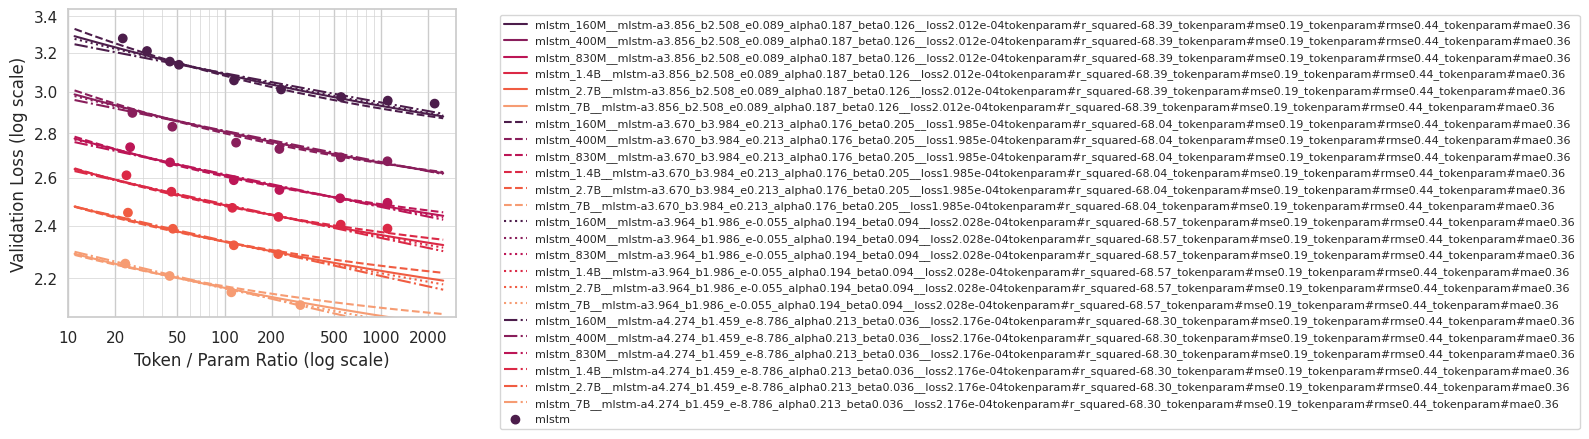

In [17]:
parametric_loss_fn_dicts = {
    "mlstm": get_first_n_fits_as_fit_fn_dict(
        ret_mlstm.sort_values(by=("val_results", "all#mse"), ascending=True),
        key_prefix="mlstm-",
        n=4,
    ),
    # "llama": get_first_n_fits_as_fit_fn_dict(
    #     ret_llama["optim_params"], key_prefix="llama-", n=3
    # ),
}
with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        ax = plot_parametric_loss_fit(
            parametric_sclaw_funcs=parametric_loss_fn_dicts,
            model_size_colormap_scale="log",
            x_axis_mode="token_param_ratio",
            plot_mode="compare_sclaw",
            yscale="log",
            xscale="log",
            # token_param_ratio_range=[11., 2500.],
            # xlim=[10, 3000],
            # ylim=[2.05, 3.7],
        )

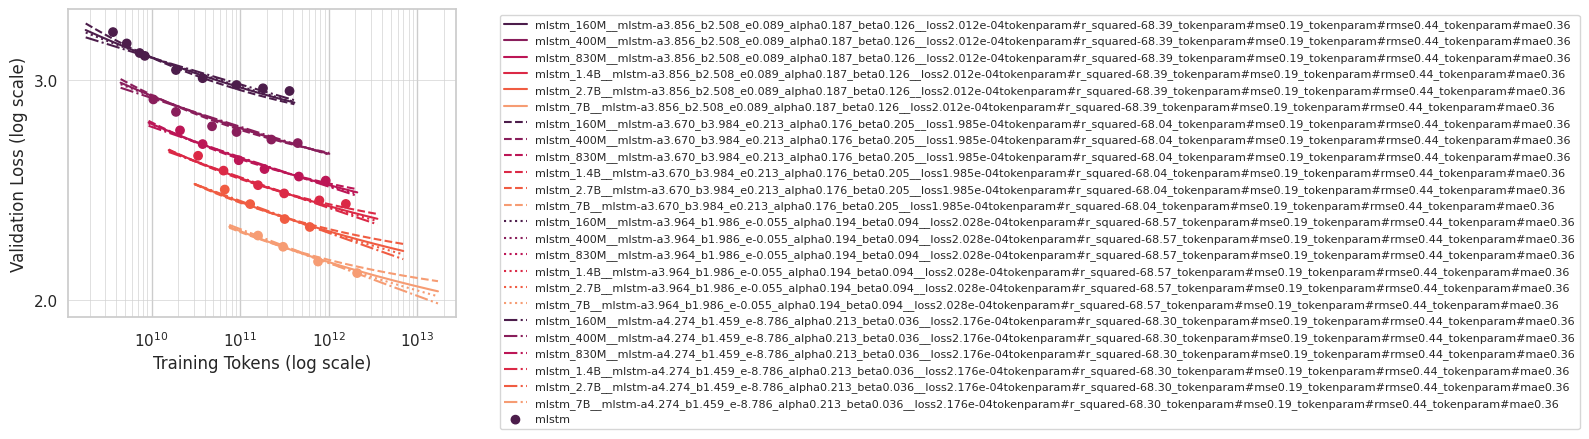

In [18]:
with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        ax = plot_parametric_loss_fit(
            parametric_sclaw_funcs=parametric_loss_fn_dicts,
            model_size_colormap_scale="log",
            x_axis_mode="num_tokens",
            plot_mode="compare_sclaw",
            yscale="log",
            xscale="log",
        )

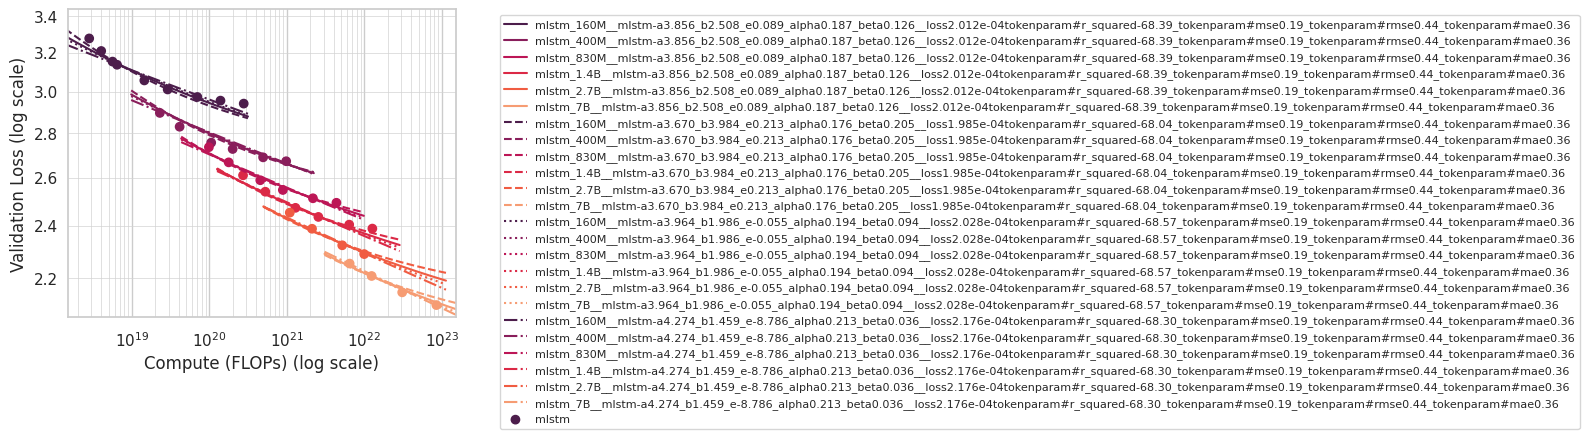

In [19]:
with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        ax = plot_parametric_loss_fit(
            parametric_sclaw_funcs=parametric_loss_fn_dicts,
            model_size_colormap_scale="log",
            x_axis_mode="num_flops",
            plot_mode="compare_sclaw",
            yscale="log",
            xscale="log",
        )

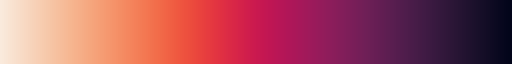

In [ ]:
# sns.color_palette("rocket_r", as_cmap=True)